# GTCRN Speech Enhancement Inference

This notebook demonstrates an end-to-end audio enhancement pipeline using a GTCRN  model for speech enhancement.

**Pipeline:**
1. **Load Audio:** Load the input mixed audio file
2. **Play Input Audio:** Play the original mixed audio
3. **Preprocess:** Convert audio to STFT representation for the model
4. **Run Inference:** Perform speech enhancement using the ONNX model
5. **Postprocess:** Convert enhanced STFT back to audio waveform
6. **Play Enhanced Audio:** Play the enhanced audio
7. **Side-by-Side Comparison:** Compare input vs enhanced audio with waveforms and spectrograms
8. **Summary:** Performance metrics and statistics

## Import Libraries and Setup

In [1]:
import os
import numpy as np
import soundfile as sf
import onnxruntime as ort
import torch
import time
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa
import librosa.display

# Setup paths
WORK_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(f"Working directory: {WORK_DIR}")

# Audio parameters
SAMPLE_RATE = 16000
N_FFT = 512
HOP_LENGTH = 256
WIN_LENGTH = 512

print("Libraries imported successfully!")

Working directory: /root/audioai-modelzoo
Libraries imported successfully!


## 1. Load ONNX Model

In [2]:
# Load ONNX model
print("Loading ONNX model...")
onnx_model_path = os.path.join(WORK_DIR, 'models', 'onnx', 'gtcrn_dns3.onnx')
session_options = ort.SessionOptions()
session_options.log_severity_level = 3  # Error level only
ort_session = ort.InferenceSession(onnx_model_path, 
                                   providers=['CPUExecutionProvider'], 
                                   sess_options=session_options)
print(f"ONNX model loaded successfully from: {onnx_model_path}")

# Print model info
input_name = ort_session.get_inputs()[0].name
input_shape = ort_session.get_inputs()[0].shape
output_name = ort_session.get_outputs()[0].name
output_shape = ort_session.get_outputs()[0].shape
print(f"Model input: {input_name} {input_shape}")
print(f"Model output: {output_name} {output_shape}")

Loading ONNX model...
ONNX model loaded successfully from: /root/audioai-modelzoo/models/onnx/gtcrn_dns3.onnx
Model input: input [1, 257, 'time', 2]
Model output: output ['Transposeoutput_dim_0', 'Transposeoutput_dim_1', 'time', 'Transposeoutput_dim_3']


## 2. Load and Play Input Audio

In [3]:
# Load input audio
input_audio_path = os.path.join(os.getcwd(), 'sample_wav', 'mix.wav')
print(f"Loading audio from: {input_audio_path}")

mix, fs = sf.read(input_audio_path, dtype='float32')
assert fs == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, got {fs}"

print(f"Audio loaded: {len(mix)} samples, {len(mix)/fs:.2f} seconds, sample rate: {fs} Hz")

# Play the original mixed audio
print("🎵 Original Mixed Audio:")
display(Audio(data=mix, rate=fs))

Loading audio from: /root/audioai-modelzoo/inference/gtcrn_sc/sample_wav/mix.wav
Audio loaded: 156302 samples, 9.77 seconds, sample rate: 16000 Hz
🎵 Original Mixed Audio:


## 3. Preprocess Audio for Model Input

In [4]:
# Compute STFT using torch with complex output
print("Computing STFT for model input...")
window = torch.hann_window(WIN_LENGTH).pow(0.5)
stft_matrix_torch = torch.stft(torch.from_numpy(mix), N_FFT, HOP_LENGTH, WIN_LENGTH, window, return_complex=True)

print(f"STFT shape: {stft_matrix_torch.shape}")

# Convert complex tensor to real/imaginary format for ONNX model
stft_real_imag = torch.stack([stft_matrix_torch.real, stft_matrix_torch.imag], dim=-1)

# Add batch dimension: (1, freq, time, 2)
input_data = stft_real_imag.unsqueeze(0).numpy().astype(np.float32)
print(f"Model input shape: {input_data.shape}")

Computing STFT for model input...
STFT shape: torch.Size([257, 611])
Model input shape: (1, 257, 611, 2)


## 4. Run Model Inference

In [5]:
# Run inference
print("Running ONNX inference...")
start_time = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: input_data}
ort_outputs = ort_session.run(None, ort_inputs)
processing_time = time.time() - start_time
print(f"Model inference time: {processing_time:.4f} seconds")
print(f"Model output shape: {ort_outputs[0].shape}")

Running ONNX inference...
Model inference time: 0.7665 seconds
Model output shape: (1, 257, 611, 2)


## 5. Postprocess and Generate Enhanced Audio

In [6]:
# Convert ONNX output back to complex tensor for ISTFT
output_real_imag = torch.from_numpy(ort_outputs[0][0])  # Shape: (freq, time, 2)
output_complex = torch.complex(output_real_imag[..., 0], output_real_imag[..., 1])

print(f"Enhanced STFT shape: {output_complex.shape}")

# Inverse STFT using torch with complex input
enh = torch.istft(output_complex, N_FFT, HOP_LENGTH, WIN_LENGTH, window)
enh_numpy = enh.detach().cpu().numpy()

print(f"Enhanced audio length: {len(enh_numpy)} samples, {len(enh_numpy)/fs:.2f} seconds")

# Save enhanced audio
output_path = os.path.join('sample_wav', 'enh_onnx.wav')
sf.write(output_path, enh_numpy, fs)
print(f"Enhanced audio saved to: {output_path}")

Enhanced STFT shape: torch.Size([257, 611])
Enhanced audio length: 156160 samples, 9.76 seconds
Enhanced audio saved to: sample_wav/enh_onnx.wav


## 6. Play Enhanced Audio

In [7]:
# Play the enhanced audio
print("🎵 Enhanced Audio:")
display(Audio(data=enh_numpy, rate=fs))

🎵 Enhanced Audio:


## 7. Side-by-Side Comparison

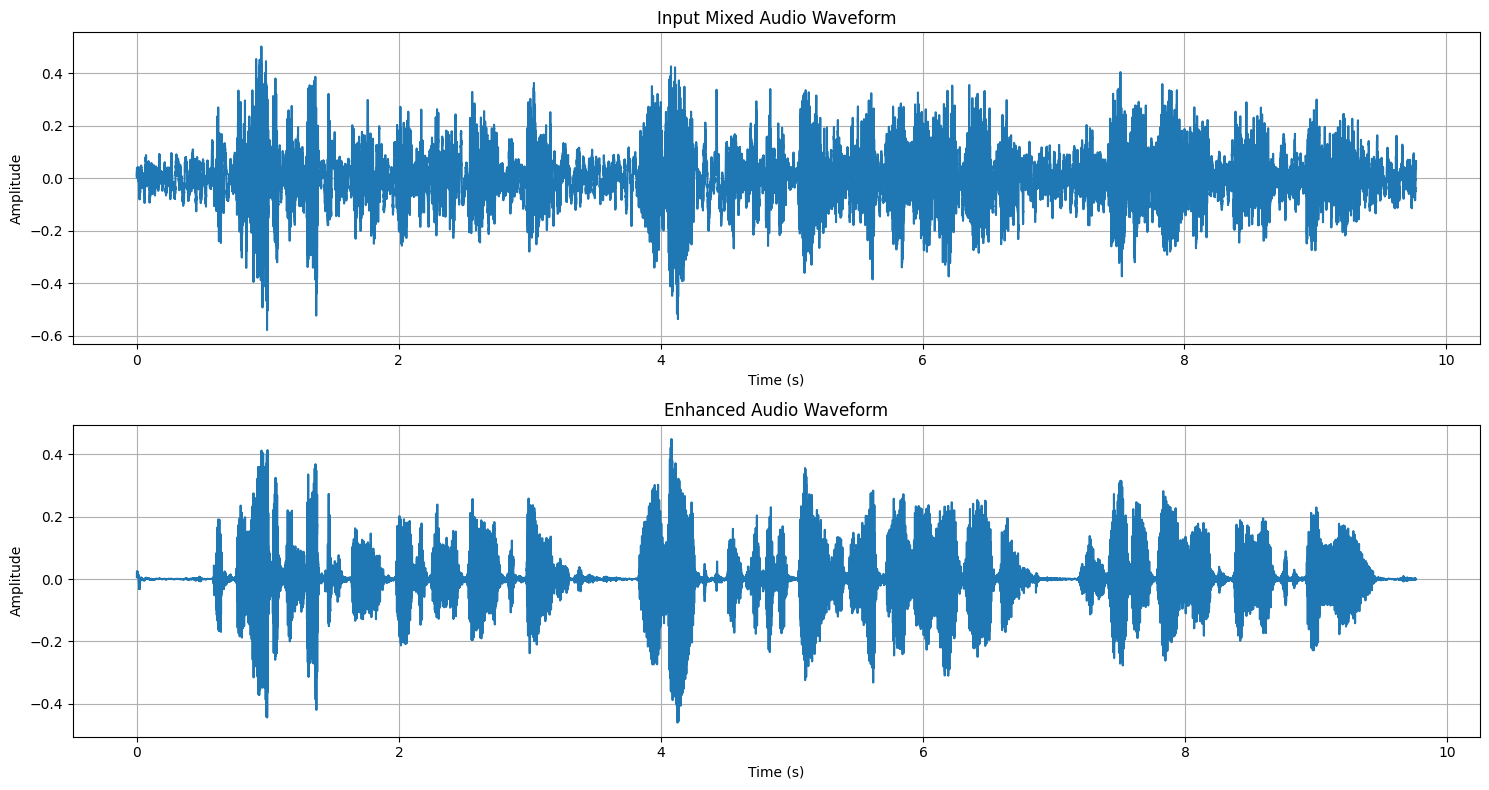

In [8]:
# Prepare data for visualization
time_axis = np.linspace(0, len(mix) / fs, len(mix))
time_axis_enh = np.linspace(0, len(enh_numpy) / fs, len(enh_numpy))

# Compute spectrograms for visualization
D_input = librosa.stft(mix, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
magnitude_db_input = librosa.amplitude_to_db(np.abs(D_input), ref=np.max)

D_enhanced = librosa.stft(enh_numpy, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
magnitude_db_enhanced = librosa.amplitude_to_db(np.abs(D_enhanced), ref=np.max)

# Compare waveforms side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Input waveform
ax1.plot(time_axis, mix)
ax1.set_title('Input Mixed Audio Waveform')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

# Enhanced waveform
ax2.plot(time_axis_enh, enh_numpy)
ax2.set_title('Enhanced Audio Waveform')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.grid(True)

plt.tight_layout()
plt.show()

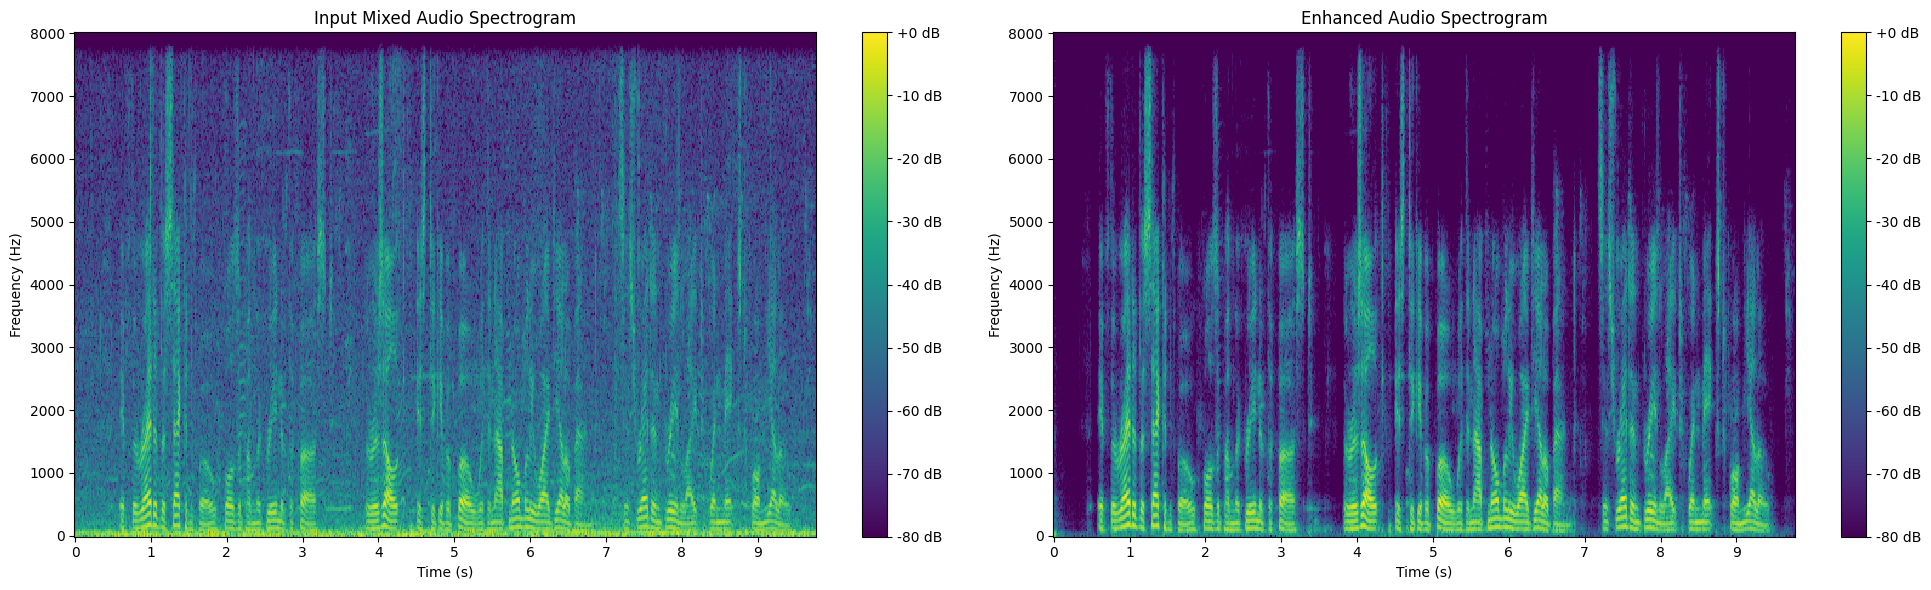

In [9]:
# Compare spectrograms side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Input spectrogram
im1 = librosa.display.specshow(magnitude_db_input, sr=fs, hop_length=HOP_LENGTH, 
                              x_axis='time', y_axis='hz', cmap='viridis', ax=ax1)
ax1.set_title('Input Mixed Audio Spectrogram')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
plt.colorbar(im1, ax=ax1, format='%+2.0f dB')

# Enhanced spectrogram
im2 = librosa.display.specshow(magnitude_db_enhanced, sr=fs, hop_length=HOP_LENGTH, 
                              x_axis='time', y_axis='hz', cmap='viridis', ax=ax2)
ax2.set_title('Enhanced Audio Spectrogram')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time (s)')
plt.colorbar(im2, ax=ax2, format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 8. Audio Comparison and Summary

In [10]:
print("=== Audio Enhancement Summary ===")
print(f"Model: GTCRN DNS3")
print(f"Input file: {os.path.basename(input_audio_path)}")
print(f"Output file: {output_path}")
print(f"Sample rate: {fs} Hz")
print(f"Audio duration: {len(mix)/fs:.2f} seconds")
print(f"Model inference time: {processing_time:.4f} seconds")
print(f"Real-time factor: {(len(mix)/fs)/processing_time:.2f}x")

# Calculate some basic audio statistics
input_rms = np.sqrt(np.mean(mix**2))
enhanced_rms = np.sqrt(np.mean(enh_numpy**2))
print(f"Audio Statistics:")
print(f"Input RMS: {input_rms:.4f}")
print(f"Enhanced RMS: {enhanced_rms:.4f}")
print(f"RMS ratio: {enhanced_rms/input_rms:.4f}")

print("🎵 Listen to both audio files above to compare the enhancement quality!")
print("Notebook execution completed successfully.")

=== Audio Enhancement Summary ===
Model: GTCRN DNS3
Input file: mix.wav
Output file: sample_wav/enh_onnx.wav
Sample rate: 16000 Hz
Audio duration: 9.77 seconds
Model inference time: 0.7665 seconds
Real-time factor: 12.75x
Audio Statistics:
Input RMS: 0.0850
Enhanced RMS: 0.0637
RMS ratio: 0.7501
🎵 Listen to both audio files above to compare the enhancement quality!
Notebook execution completed successfully.
